# Refactoring temperature

Basic data and imports.

In [2]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

Make designer.

In [5]:
import numpy as np
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints),
    reactions,
    cache = True
)

In [435]:
self = designer.generator

In [436]:
%%time
sizes = get_size(self.fingerprints.ids)
sizes = torch.tensor([sizes])

CPU times: user 77.4 ms, sys: 177 µs, total: 77.5 ms
Wall time: 83.8 ms


In [564]:
%%time
import torch

temperature = 1.0

molecules = [deck[0].reactants[0]]
fingerprint_type = self.fingerprints.get_fingerprint_type()
fingerprints = [
    (m.name, fingerprint_type.from_smi(m.smiles))
    for m in molecules
]

queries = chemfp.load_fingerprints(
    fingerprints,
    metadata = fingerprint_type.get_metadata(),
    reorder=False
)

results = chemfp.simsearch(
    queries = queries,
    targets = self.fingerprints,
    progress = False,
    threshold = 0.0,
    # k = 500
)

CPU times: user 5.65 ms, sys: 0 ns, total: 5.65 ms
Wall time: 5.64 ms


In [636]:
%%time
scores = torch.tensor(results.to_csr().A)

CPU times: user 3.51 ms, sys: 0 ns, total: 3.51 ms
Wall time: 1.76 ms


In [637]:
scores += self.size_similarity(molecules, sizes)

In [638]:
%%time
temperature = 0.0
probabilities = self.boltzmann(scores, temperature)
samples_idx = torch.multinomial(probabilities, 200)
samples = torch.gather(indices, 1, samples_idx).tolist()

CPU times: user 19.5 ms, sys: 1.67 ms, total: 21.2 ms
Wall time: 2.53 ms


In [639]:
strict = False
generators = [
    self._generator_factory(sampler, molecule, strict=strict)
    for sampler, molecule in zip(samples, molecules)
]

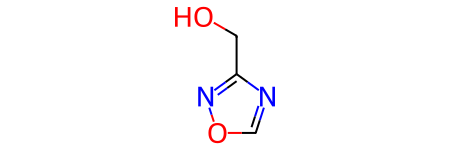

In [719]:
next(generators[0])